In [1]:
from typing import Dict, List

import pandas as pd
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

In [2]:
def style_wrapper(
        axis, title=None, x_label=None, y_label=None, show_legend=True,
        x_start=None, y_start=None
):
    """
    Custom styling for matplotlib axis. Adds horizontal grid lines, sets ax limits and titles.
    """

    axis.yaxis.grid(True, linewidth=1)
    axis.set_axisbelow(True)

    # Set axis start at 0
    if x_start is not None:
        axis.set_xlim(left=x_start)
    if y_start is not None:
        axis.set_ylim(bottom=y_start - 0.1 * abs(y_start))

    # Set titles/axis labels
    if title:
        axis.set_title(title, fontsize=12)
    if x_label:
        axis.set_xlabel(x_label, fontsize=12)
    if y_label:
        axis.set_ylabel(y_label, fontsize=12)

    axis.tick_params(axis='x', labelsize=12)
    axis.tick_params(axis='y', labelsize=12)

    # Toggle legend
    if show_legend:
        axis.legend()

In [3]:
def plot_line(
        ax: Axes,
        df: pd.DataFrame,
        column_name: str,
        model_dict: Dict[str, str],
        x_col: str = 'train/global_step',
        title: str = None,
        x_label: str = None,
        y_label: str = None,
        show_legend: bool = True,
        y_start_at_zero: bool = False
):
    """
    Helper function to generate line plots.
    """
    min_x = float('inf')
    min_y = float('inf')
    for run_name, model_config in model_dict.items():
        if model_config['model_name'] != 'base' and model_config['model_name'] != 'sft':
            y_col = f'{run_name} - {column_name}'
            label = model_config['model_name'].replace('_', ' ').upper()
            ax.plot(df[x_col], df[y_col], label=label,
                    linestyle=model_config['line_style'], marker=model_config['marker'])
            if df[x_col].min() < min_x:
                min_x = df[x_col].min()

            if df[y_col].min() < min_y:
                min_y = df[y_col].min()

    if y_start_at_zero:
        min_y = 0

    style_wrapper(ax, title, x_label, y_label, show_legend, min_x, min_y)

In [4]:
model_names = {
    'Qwen2_5-3B-Instruct-lr1e-05-ws50-cosine-beta0_1': {
        'model_name': 'base_dpo',
        'marker': 'o',
        'line_style': '-'
    },
    'Qwen2_5-3B-Instruct-lr1e-05-ws50-cosine-beta0_1-dpol0_95-fixed': {
        'model_name': 'base_dpo_shift',
        'marker': 's',
        'line_style': '--'
    },
    'Qwen2_5-3B-persona-SFT-lr1e-05-ws50-cosine-beta0_1': {
        'model_name': 'sft_dpo',
        'marker': 'D',
        'line_style': '-.'
    },
    'Qwen2_5-3B-persona-SFT-lr1e-05-ws50-cosine-beta0_1-dpol0_95-fixed': {
        'model_name': 'sft_dpo_shift',
        'marker': 'v',
        'line_style': ':'
    },
    'Qwen2_5-3B-persona-SFT': {
        'model_name': 'sft',
        'marker': 'o',
        'line_style': '-'
    },
    'Qwen2_5-3B': {
        'model_name': 'base',
        'marker': 's',
        'line_style': ':'
    },
}

## Reward Plotting

In [44]:
def lineplot_pipeline(
    file_names: List[str],
):
    """
    Helper function for loading data and determining titles for figures.
    """
    for idx, file in enumerate(file_names):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        data = pd.read_csv(f'train_data/{file}.csv')

        ax_title = ' '.join(word.capitalize() for word in file.split('_'))
        col_name = '/'.join(file.split('_'))
        ax_y_col = 'Accuracy' if 'accuracies' in file else 'Reward Score'

        show_legend = True if 'accuracies' in file else False
        y_start_at_zero = True if 'margins' in file else False

        plot_line(
            ax,
            data,
            col_name,
            model_names,
            'train/global_step',
            ax_title,
            'Step',
            ax_y_col,
            show_legend=show_legend,
            y_start_at_zero=y_start_at_zero
        )

        plt.tight_layout()
        plt.savefig(f'report_figures/{file}.png', dpi=1200)
        plt.show()

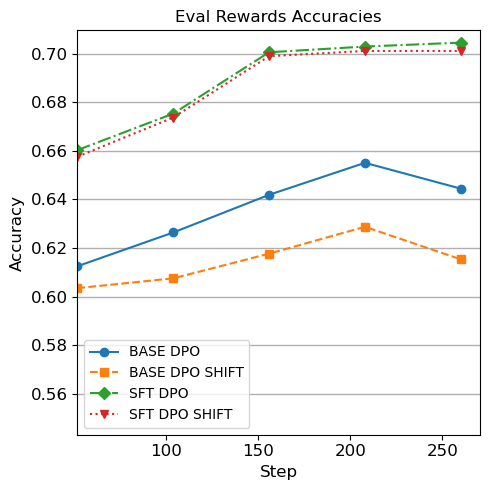

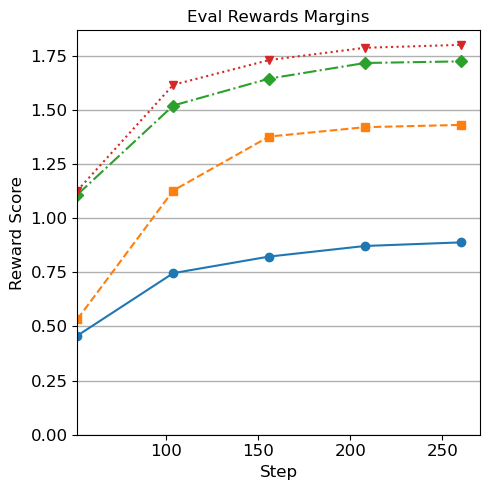

In [47]:
eval_rewards_files = ['eval_rewards_accuracies', 'eval_rewards_margins']
lineplot_pipeline(eval_rewards_files)

## Accuracy Plotting

In [ ]:
accuracy_files = ['train_rewards_accuracies', 'eval_rewards_accuracies']
lineplot_pipeline(accuracy_files)

## Per Category

In [5]:
# Calculate the margins between logps chosen and logps rejected for each model and train split
metrics_per_model = {}
for model_repo, model_config in model_names.items():
    model_name = model_config['model_name']

    model_dict = {}
    for data_split in ['test', 'train']:
        metric_df = pd.read_csv(f'train_data/per_category/{model_name}_{data_split}.csv')
        metric_df['margin'] = metric_df['eval_logps/chosen'] - metric_df['eval_logps/rejected']
        df_model = metric_df[['Category', 'margin', 'eval_logps/chosen']].copy()

        model_dict[data_split] = df_model
    metrics_per_model[model_name] = model_dict

In [6]:
combined_margins = {}
for split in ['train', 'test']:
    model_dfs = []

    for model_name, splits in metrics_per_model.items():
        if model_name == 'base':
            continue

        # Load original csvs
        model_csv_path = f'train_data/per_category/{model_name}_{split}.csv'
        base_csv_path = f'train_data/per_category/base_{split}.csv'
        model_df = pd.read_csv(model_csv_path).set_index('Category')
        base_df = pd.read_csv(base_csv_path).set_index('Category')

        # Compute margins
        chosen_diff = model_df['eval_logps/chosen'] - base_df['eval_logps/chosen']
        margin_model = model_df['eval_logps/chosen'] - model_df['eval_logps/rejected']
        margin_base = base_df['eval_logps/chosen'] - base_df['eval_logps/rejected']
        combined_margin = margin_model - margin_base

        # Create dataframe for this model
        df_model = pd.DataFrame({
            f'{model_name}_chosen_diff': chosen_diff,
            f'{model_name}_margin_model': margin_model,
            f'{model_name}_margin_base': margin_base,
            f'{model_name}_margin_model_base': combined_margin
        })

        model_dfs.append(df_model)

    # Combine all models' columns by Category
    if model_dfs:
        combined_df = pd.concat(model_dfs, axis=1)
        combined_margins[split] = combined_df

## Biggest Margin Improvements

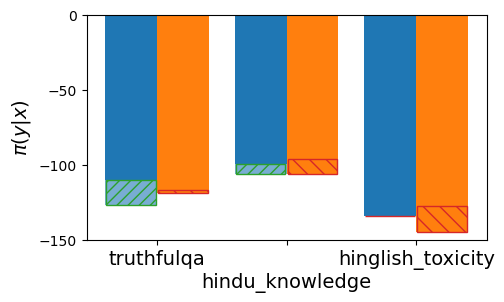

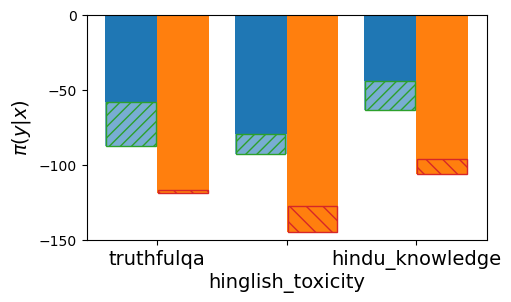

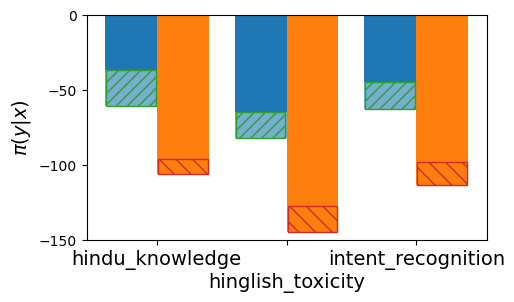

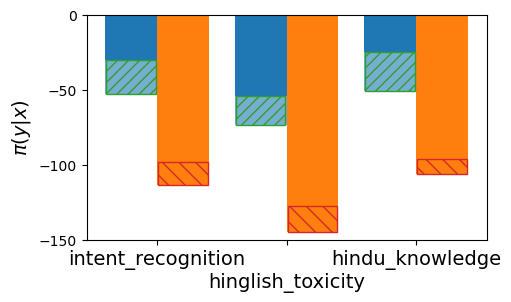

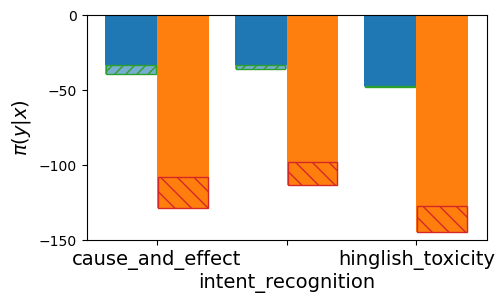

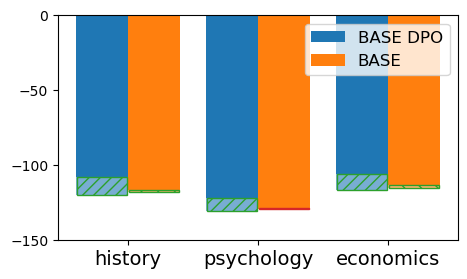

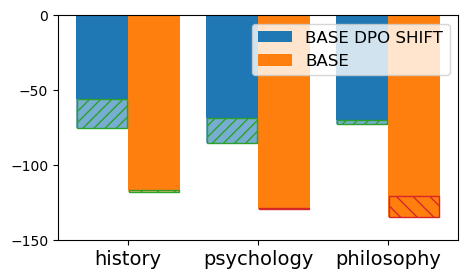

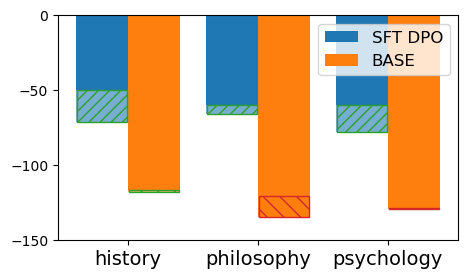

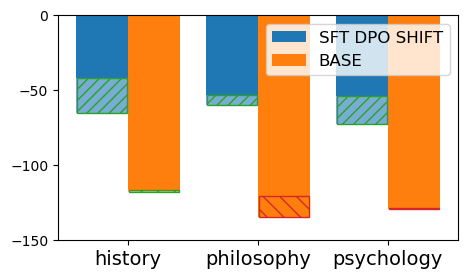

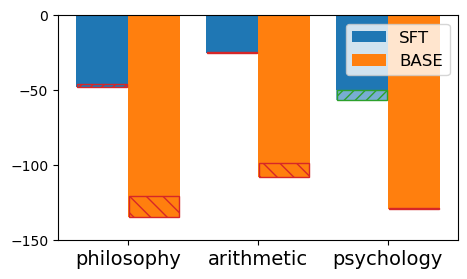

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

for split in ['train', 'test']:
    combined_df = combined_margins[split]

    for model_name, splits in metrics_per_model.items():
        if model_name == 'base':
            continue

        chosen_col = f'{model_name}_margin_model_base'

        # Get top 3 categories
        top3_cats = combined_df[chosen_col].sort_values(ascending=False).head(3).index.tolist()

        # For each category, determine margin and logps
        bar_vals = []
        cat_margins = []
        for cat in top3_cats:
            model_csv = f'train_data/per_category/{model_name}_{split}.csv'
            base_csv = f'train_data/per_category/base_{split}.csv'

            model_df = pd.read_csv(model_csv).set_index('Category')
            base_df = pd.read_csv(base_csv).set_index('Category')

            model_chosen_val = model_df.loc[cat, 'eval_logps/chosen']
            model_rejected_val = model_df.loc[cat, 'eval_logps/rejected']
            base_chosen_val = base_df.loc[cat, 'eval_logps/chosen']
            base_rejected_val = base_df.loc[cat, 'eval_logps/rejected']

            vals = [
                model_chosen_val,
                model_rejected_val,
                base_chosen_val,
                base_rejected_val
            ]
            bar_vals.append(vals)

            model_margin = model_chosen_val - model_rejected_val
            base_margin = base_chosen_val - base_rejected_val
            cat_margins.append([model_margin, base_margin])

        cat_abbreviations = []
        for cat in top3_cats:
            cat_abbreviations.append(cat)

        if not bar_vals:
            continue

        bar_vals = np.array(bar_vals)

        # Labels per model
        bar_labels = [f'{model_name.replace("_", " ").upper()}', 'BASE']
        color = ['tab:blue', 'tab:orange']
        n_bars_per_group = 4
        n_groups = len(bar_vals)

        fig, ax = plt.subplots(figsize=(5, 3))
        ax.set_position([0.15, 0.2, 0.8, 0.75])

        # Positioning and size of bars
        spacing = 0.25
        group_pos = np.arange(n_groups) * spacing
        bar_width = 0.1
        offsets = np.linspace(-0.5 * bar_width, 0.5 * bar_width, 2)

        # Plot each bar within groups
        for i in range(n_bars_per_group):
            # Rejected bars have opacity 0.6
            if i % 2 == 0:
                ax.bar(group_pos + offsets[i // 2], bar_vals[:, i], width=bar_width,
                        label=bar_labels[i // 2], color=color[i // 2])
            else:
                ax.bar(group_pos + offsets[i // 2], bar_vals[:, i], width=bar_width,
                        color=color[i // 2], alpha=0.6)

        # Add margin indication boxes to graphs
        for i, cat in enumerate(top3_cats):
            model_chosen, model_rejected, base_chosen, base_rejected = bar_vals[i]
            y_pos = group_pos[i]

            # For model
            rect_color = 'tab:red' if cat_margins[i][0] < 0 else 'tab:green'
            width = abs(cat_margins[i][0])
            rect = patches.Rectangle(
                (y_pos - 0.002, min(model_rejected, model_chosen)),
                -(bar_width - 0.004), width, linewidth=1, edgecolor=rect_color,
                facecolor='none', hatch='///'
            )
            ax.add_patch(rect)

            # For base
            width = abs(cat_margins[i][1])
            rect_color = 'tab:red' if cat_margins[i][1] < 0 else 'tab:green'
            base_rect = patches.Rectangle(
                (y_pos + 0.002, min(base_rejected, base_chosen)),
                bar_width - 0.004, width, linewidth=1, edgecolor=rect_color,
                facecolor='none', hatch='\\\\'
            )
            ax.add_patch(base_rect)

        ax.set_xticks(group_pos)
        ax.set_xticklabels(cat_abbreviations, fontsize=14)

        # Only train split has y label, x labels are indented
        if split != 'test':
            for i, label in enumerate(ax.get_xticklabels()):
                if i % 2 == 1:
                    label.set_y(label.get_position()[1] - 0.10)
            ax.set_ylabel(r'$\pi(y|x)$', fontsize=14)
        ax.set_ylim(-150, 0)

        ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
        if split == 'test':
            ax.legend(loc='upper right', fontsize=12)
        plt.show()

        fig.savefig(f'report_figures/margins/{model_name}_{split}.png', dpi=1200)

## Presentation Plot

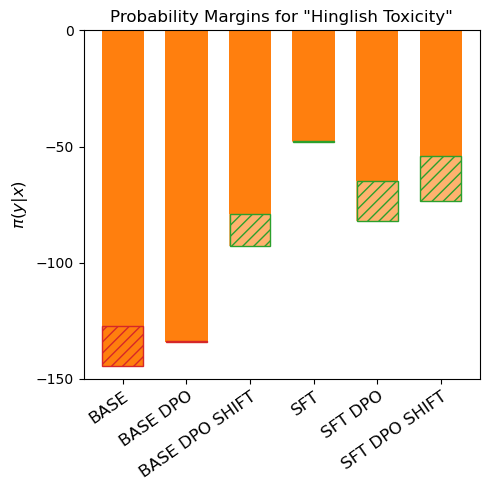

In [60]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

for split in ['train']:
    combined_df = combined_margins[split]

    category = 'hinglish_toxicity'

    # For each model, determine margin and logps
    bar_vals = []
    cat_margins = []
    bar_labels = []
    for model_name in ['base', 'base_dpo', 'base_dpo_shift', 'sft', 'sft_dpo', 'sft_dpo_shift']:
        bar_labels.append(model_name)

        chosen_col = f'{model_name}_margin_model_base'

        model_csv = f'train_data/per_category/{model_name}_{split}.csv'
        base_csv = f'train_data/per_category/base_{split}.csv'

        model_df = pd.read_csv(model_csv).set_index('Category')
        base_df = pd.read_csv(base_csv).set_index('Category')

        model_chosen_val = model_df.loc[category, 'eval_logps/chosen']
        model_rejected_val = model_df.loc[category, 'eval_logps/rejected']
        base_chosen_val = base_df.loc[category, 'eval_logps/chosen']
        base_rejected_val = base_df.loc[category, 'eval_logps/rejected']

        vals = [
            model_chosen_val,
            model_rejected_val,
        ]
        bar_vals.append(vals)

        model_margin = model_chosen_val - model_rejected_val
        cat_margins.append(model_margin)

    bar_vals = np.array(bar_vals)

    # Labels per model
    fig, ax = plt.subplots(figsize=(5, 5))

    # Positioning and size of bars
    spacing = 0.3
    group_pos = np.arange(len(bar_labels)) * spacing
    bar_width = 0.2
    # offsets = np.linspace(-1.5 * bar_width, 1.5 * bar_width, group_pos)

    # Plot each bar within groups
    ax.bar(group_pos, bar_vals[:, 0], width=bar_width, color='tab:orange')
    ax.bar(group_pos, bar_vals[:, 1], width=bar_width, color='tab:orange', alpha=0.6)

    # Add margin indication boxes to graphs
    for i, cat in enumerate(cat_margins):
        model_chosen, model_rejected = bar_vals[i]
        y_pos = group_pos[i]

        # For model
        rect_color = 'tab:red' if cat_margins[i] < 0 else 'tab:green'
        width = abs(cat_margins[i])
        rect = patches.Rectangle(
            (y_pos - bar_width / 2 + 0.004, min(model_rejected, model_chosen)),
            (bar_width - 0.008), width, linewidth=1, edgecolor=rect_color,
            facecolor='none', hatch='///'
        )
        ax.add_patch(rect)

    ax.set_xticks(group_pos)
    ax.set_xticklabels([label.replace('_', ' ').upper() for label in bar_labels], fontsize=12,
                       rotation=35, ha='right', rotation_mode='anchor')

    # Only train split has y label, x labels are indented
    ax.set_ylabel(r'$\pi(y|x)$', fontsize=12)
    ax.set_ylim(-150, 0)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.set_title('Probability Margins for "Hinglish Toxicity"')
    plt.tight_layout()
    plt.show()

    fig.savefig(f'report_figures/presentation_plot_margins.png', dpi=1200)